# Классификация текста с использованием LSTM и квантовых нейросетей

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BDF1600BE0>>
Traceback (most recent call last):
  File "C:\Users\den1s\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.despine()
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [3]:
num_qubits = 4
device = "cpu"
dev = qml.device("lightning.qubit", wires=range(num_qubits))

В проекте используется датасет "Cyberbullying Classification" с Kaggle. Информацию о датасете можно узнать, перейдя по ссылке: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data

In [4]:
df = pd.read_csv("data\cut_data_for_study.csv")
df.head()

,text,sentiment,text_clean,text_len
0,"Make no mistake, you are the ones struggling. ...",1,make mistake one struggling lmao need proof ob...,11
1,@Zeke311 Now if Hollande and other leaders wil...,1,hollande leader understand islam quran radical...,9
2,#BringBackPayal @TwitterIndia u ar biased towa...,1,bringbackpayal ar biased towards islamic terro...,6
3,Yes...I am a white Christian woman and I also ...,1,yesi white christian woman also voting preside...,10
4,@Vandaliser @sajid_fairooz @IsraeliRegime Fina...,1,finally backwards effect islam ground progress...,9


In [5]:
df["sentiment"].value_counts()


sentiment
1    3000
0    3000
Name: count, dtype: int64

In [6]:
max_len = np.max(df['text_len'])
max_len

16

In [7]:
def Tokenize(column, seq_len):
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [8]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [9]:
EMBEDDING_DIM = 200
VOCAB_SIZE = len(vocabulary) + 1

In [10]:
X = tokenized_column
y = df['sentiment'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [29]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        hidden = hidden[-1]
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        print(hidden_repeated.shape, encoder_outputs.shape)
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        attn_weights = self.v(attn_weights).squeeze(2)
        return nn.functional.softmax(attn_weights, dim=1)

In [30]:
class ClassicalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers):
        super(ClassicalModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        attn_weights = self.attention(hidden[0], out)
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0.to(device), c0.to(device)

In [31]:
qdi_reps1 = 2
qdi_reps2 = 2
qdi_depth = 1

In [32]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    for r in range(qdi_reps2):
        for i in range(len(wires)):
            qml.RX(weights[qdi_reps1+r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
    return [qml.expval(qml.PauliY(w)) for w in wires]

c:\qml\mentor\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\qml\mentor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


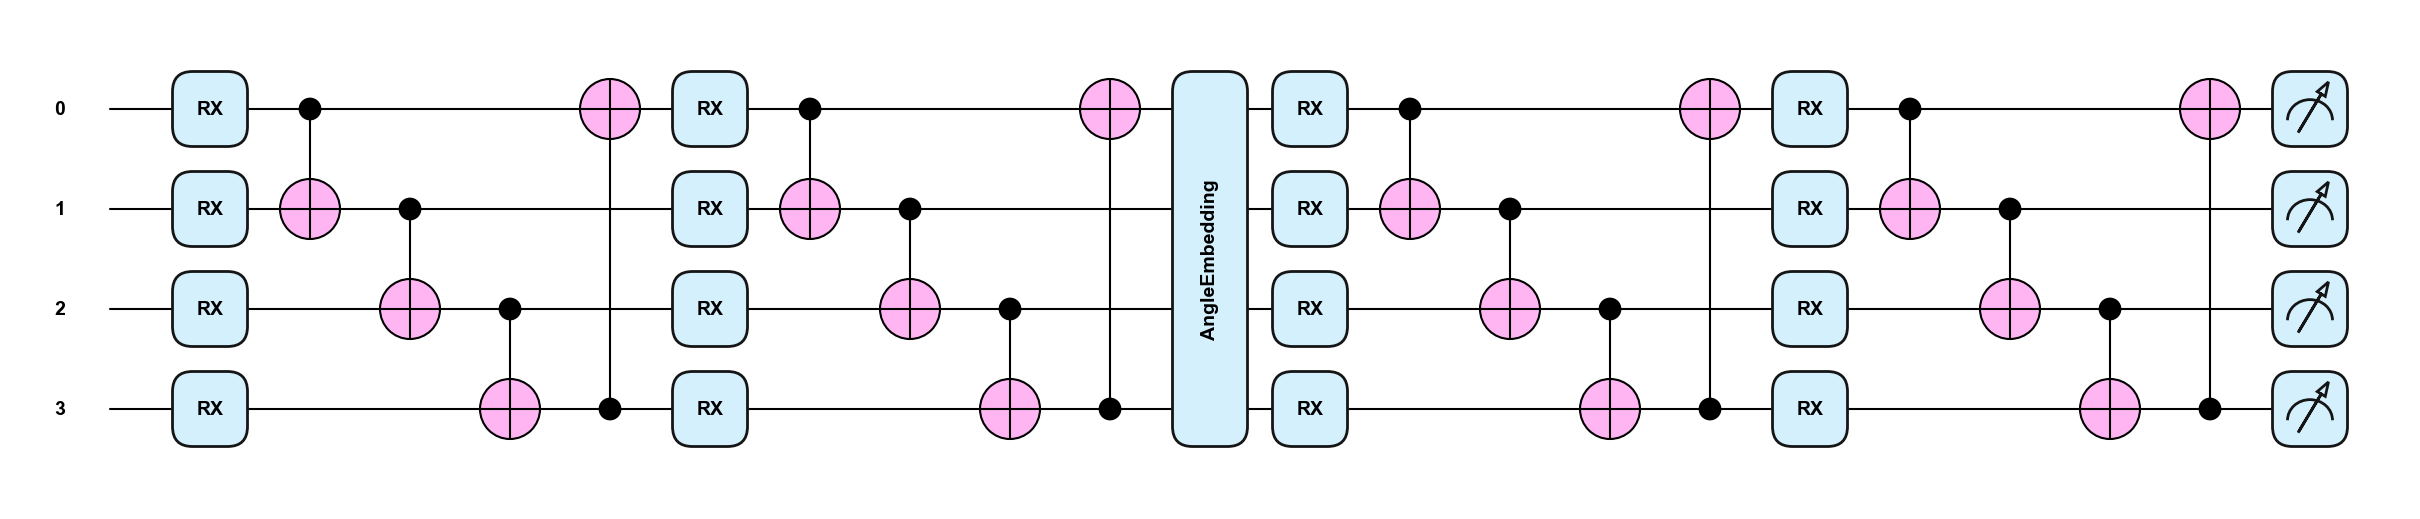

In [33]:
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(qdi_circuit)(torch.rand((qdi_reps1 + qdi_reps2, num_qubits)), torch.rand((4, 4)))

In [34]:
class HQLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits):
        super(HQLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_input = nn.Parameter(torch.rand(4 * num_qubits, input_size), requires_grad = True).float()
        self.W_hid = nn.Parameter(torch.rand(4 * num_qubits, hidden_size), requires_grad = True).float()
        self.W_quan = nn.Parameter(torch.zeros(4, qdi_reps1 + qdi_reps2, num_qubits), requires_grad = True).float()
        self.W = nn.Parameter(torch.rand(4, hidden_size, num_qubits), requires_grad = True).float()

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        yield_input = F.linear(x, self.W_input)
        yield_hidden = F.linear(h_prev, self.W_hid)
        combined = yield_input + yield_hidden

        i_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[0], combined[:, :num_qubits].reshape(-1, num_qubits))).T.float(), self.W[0])
        f_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[1], combined[:, num_qubits:2*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[1])
        g_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[2], combined[:, 2*num_qubits:3*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[2])
        o_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[3], combined[:, 3*num_qubits:4*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[3])

        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)

        c_next = (f_gate * c_prev) + (i_gate * g_gate)

        h_next = o_gate * torch.tanh(c_next)

        return h_next, c_next


class HQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits, num_layers=1):
        super(HQLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList([HQLSTMCell(input_size if l==0 else hidden_size, hidden_size, num_qubits) for l in range(num_layers)])


    def forward(self, x, hidden=None):
        batch_size, seq_len, _ = x.size()

        if hidden is None:
             h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
             c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        else:
            h0, c0 = hidden

        output_seq = []

        for t in range(seq_len):
            input_t = x[:, t, :] 

            new_h = []
            new_c = []

            for layer in range(self.num_layers):

                h_t, c_t = self.lstm_cells[layer](input_t, (h0[layer], c0[layer]))

                new_h.append(h_t)
                new_c.append(c_t)
                input_t = h_t 

            h0 = torch.stack(new_h)
            c0 = torch.stack(new_c)
            output_seq.append(h_t.unsqueeze(1))

        output_seq = torch.cat(output_seq, dim=1)

        return output_seq, (h0, c0)


In [35]:
class HybridQuantumModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(HybridQuantumModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded)
        print(out.shape, hidden[0].shape)
        attn_weights = self.attention(hidden[0], out)
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        out = self.softmax(self.fc(context))
        return out

In [36]:
NUM_CLASSES = 2 
HIDDEN_DIM = 64
LSTM_LAYERS = 1


LR = 6e-4
EPOCHS = 10

criterion = nn.NLLLoss()

In [38]:
import time

def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))
            preds, h = model(X, h)

            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().cpu().numpy()
            # print(f'batch: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))

            with torch.no_grad():
                preds, h = model(X, h)
                loss = criterion(preds, y)

                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def train_for_hqnn(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0

        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            preds = model(X)

            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            end_time = time.time()
            execution_time = end_time - start_time

            train_loss += loss.detach().cpu().numpy()
            print(f'it: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        train_accuracy_arr[i_epoch] = train_accuracy

        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]


            with torch.no_grad():
                preds = model(X)
                loss = criterion(preds, y)

                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
        if test_loss >= np.max(test_losses):
            torch.save(model.state_dict(), 'hq_model_weights.pth')

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

def evaluate_hq_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for batch in test_loader:
            X = batch[0]
            y = batch[1]

            preds = model(X)
            y_pred_test = torch.argmax(preds, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(y.squeeze().tolist())
    
    return y_pred_list, y_test_list

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
def make_report(model_type, batch_size, hidden_dim, num_epochs):
    '''model types: 'hq' and 'cl' '''
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    LR = 6e-4

    criterion = nn.NLLLoss()

    if model_type == 'hq':
        model = HybridQuantumModel(VOCAB_SIZE, EMBEDDING_DIM, hidden_dim, 4, NUM_CLASSES, LSTM_LAYERS)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
        train_losses, _, _, test_accuracy_arr = train_for_hqnn(model, criterion=criterion,
                                optimizer=optimizer,
                                train_dataloader=train_loader,
                                test_dataloader=test_loader,
                                num_epochs=num_epochs)
        y_pred_list, y_test_list = evaluate_hq_model(model, test_loader)
    elif model_type == 'cl':
        model = ClassicalModel(VOCAB_SIZE, EMBEDDING_DIM, hidden_dim, NUM_CLASSES, LSTM_LAYERS)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
        train_losses, _, _, test_accuracy_arr = train(model, criterion=criterion,
                                optimizer=optimizer,
                                train_dataloader=train_loader,
                                test_dataloader=test_loader,
                                num_epochs=num_epochs)
        y_pred_list, y_test_list = evaluate_model(model, test_loader)
    else:
        print("wrong model type")
        return
    report = {
        'model type': model_type,
        'batch size': batch_size,
        'hidden dim': hidden_dim,
        'epochs': num_epochs,
        'test accuracy_arr': test_accuracy_arr,
        'train losses arr': train_losses, 
        'classification report': classification_report(y_test_list, y_pred_list, target_names=["cyberbullying", "not_cyberbullying"]),
        'confusion matrix': confusion_matrix(y_test_list, y_pred_list)
    }
    return report

In [ ]:
cl32Report = make_report(model_type='cl', batch_size=32, hidden_dim=32, num_epochs=20)
cl64Report = make_report(model_type='cl', batch_size=32, hidden_dim=64, num_epochs=20)
cl128Report = make_report(model_type='cl', batch_size=32, hidden_dim=128, num_epochs=20)

In [ ]:
hq32Report = make_report(model_type='hq', batch_size=32, hidden_dim=32, num_epochs=15)
hq64Report = make_report(model_type='hq', batch_size=32, hidden_dim=64, num_epochs=15)
hq128Report = make_report(model_type='hq', batch_size=32, hidden_dim=128, num_epochs=15)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(np.arange(1, 4), cl32Report["train losses arr"].numpy(), label=r'$h=32$')
ax[0].plot(np.arange(1, 4), cl64Report["train losses arr"].numpy(), label=r'$h=64$')
ax[0].plot(np.arange(1, 4), cl128Report["train losses arr"].numpy(), label=r'$h=128$')
ax[0].set_xticks(np.arange(1, cl128Report["train losses arr"].numpy().shape[0], 4))
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(1, 4), cl32Report["test accuracy_arr"].numpy(),
           label=r'$h=32$')
ax[1].plot(np.arange(1, 4), cl64Report["test accuracy_arr"].numpy(),
           label=r'$h=64$')
ax[1].plot(np.arange(1, 4), cl128Report["test accuracy_arr"].numpy(),
           label=r'$h=128$')
ax[1].set_xticks(np.arange(0, cl128Report["test accuracy_arr"].numpy().shape[0], 4))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Сравнение показателей классических моделей для разных размеров скрытого состояния h', loc='center')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(np.arange(1, 4), hq32Report["train losses arr"].numpy(), label=r'$h=32$')
ax[0].plot(np.arange(1, 4), hq64Report["train losses arr"].numpy(), label=r'$h=64$')
ax[0].plot(np.arange(1, 4), hq128Report["train losses arr"].numpy(), label=r'$h=128$')
ax[0].set_xticks(np.arange(1, hq128Report["train losses arr"].numpy().shape[0], 4))
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(1, 4), hq32Report["test accuracy_arr"].numpy(),
           label=r'$h=32$')
ax[1].plot(np.arange(1, 4), hq64Report["test accuracy_arr"].numpy(),
           label=r'$h=64$')
ax[1].plot(np.arange(1, 4), hq128Report["test accuracy_arr"].numpy(),
           label=r'$h=128$')
ax[1].set_xticks(np.arange(0, hq128Report["test accuracy_arr"].numpy().shape[0], 4))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Сравнение показателей гибридных моделей для разных размеров скрытого состояния h', loc='center')
plt.show()